# Introduction
 
In this notebook I will outline the approach used to apply the data from the experiments to the theory. The ultimate aim is to generate predictions as to how interactions between species within a community affect the temperature sensitivity of its emergent respiartory carbon flux. First I will outline the theory associated with the model fiting, what models I will use and the information that will be required to infer parameters. Then I will apply these methods to the data from the experiments, derive parameter estimates. Finally I will use these to predict the emergent carbon flux and its temperature sensitvity, comparing these to the real data.

# The Theory

As discussed in the previous notebook the carbon flux of any multispecies ecosystem is given by:

$$
R_{eco} = \sum_{i = 1}^{N} R_{i} \ C_{i}
$$

where $R_{eco}$ is the total respiratory carbon flux of an ecosystem and $R_{i}$ and $C_{i}$ are the mass-specific respiration and carbon biomass of species $i$ respectively. We can further decompose the biomass component here by considering that the growth rate of any species population is given by some function of it's intrinsic growth rate $r_i$ and biomasses of all species in the system via interactions, $\vec{C}$ with a set of parameters $\vec{\theta}$ determingin the nature of these interactions:

$$
\frac{dC_i}{dt} = f(r_i,\vec{C},\vec{\theta})
$$

of which the integral gives the biomass at any time $t$:

$$
\int \frac{dC_i}{dt} dt = \int f(r_i,\vec{C},\vec{\theta}) dt = C_i(t,r_i,\vec{C},\vec{\theta})
$$

Thus we can see that total flux in a system will depend based on the nature of the interaction between species ($\vec{\theta}$) as biomass dynamics change over time:

$$
R_{eco} = \sum_{i = 1}^{N} R_{i} \ C(t,r_i,\vec{C},\vec{\theta})
$$

## Temperature

As per ecological metabolic theory, we expect that temperature will affect metabolic processes occuring within indivduals due to the fundamental biochemical basis for these processes. In the case of the model above temperature enters at three points. Firstly it directly affects the rate of respiration, $R_i(T)$. Secondly it indirectly affects the biomass component  intrinsic rate of growth $r_i(T)$. And lastly via the nature of interactions between species $\vec{\theta}(T)$. Over time this last two will cause changes in biomasses of species (i.e. higher growth rates will result in more biomass or stronger competitve interactions will result in less biomass), changing the total respiration in the system. Thus we can rewrite the equation above as:

$$
R_{eco} = \sum_{i = 1}^{N} R_{i}(T) \ C(t,r_i(T),\vec{C},\vec{\theta}(T))
$$

clearly indicating the temperature dependence of total ecosystem respiration. Though the equation above is not analytically solveable (due to the complexities that arrise when considering multiple interacting components) we can use numerical simulations to see how the biomass dynamics change over time and how temperature affect this process (see the previous notebook).

## A model for ecosystem dynamics

The equation above represents the general case for an ecosystem and encompasses all models that describe ecosystem dynamics, depending on the form of the function $f(.)$. In order to derive any predictions for biomass dynamics we must make explicit how species populations grow and interact. The simplest model to use is the generalised lotka-volterra (GLV) which has the form:

$$
\frac{dC_i}{dt} = f_i(.) = C_i(r_i(T) + \sum_{j = 1}^{N} a_{ij}(T) C_j)
$$

where $a_{ij}$ is the interaction coefficent describing the effect of species $j$ upon species $i$

We can write total ecosystem respiration including the solution to this growth equation:

$$
R_{eco} = \sum_{i = 1}^{N} R_{i}(T) \int C_i(r_i(T) + \sum_{i = 1}^{N} a_{ij}(T) C_j) \ dt
$$

Thus we need three parameters to work out R_{eco}:
* $R_{i}(T)$ - Respiration for each species
* $r_i(T)$ - The intrinsic growth rate for each species
* $a_{ij}(T)$ - The interaction terms for each species pair 

Bellow I discuss how each of these parameters can be infered from the experimental data.

### Respiration - $R_i(T)$

Respiration and its temperature dependence are relatively easy to parameterise given the experimetnal data. We have good measures of respiration for each species across a range of temperatures. We can fit sharpe-scholefield models to these to characterise them mathermatically. 

### growth rates - $r_i(T)$
Parameterising the growth rates is also relatively straightforward depending on the data. Though growth rate was not measured explictly over different temperatures (i.e. with logistic curve fits) we have measurements of optical density (OD) before and after the respiration measurements we taken, with the time interval recorded. Thus we can assume exponential growth and use the following formula to estimate growth rate:

$$
r_i = \frac{log(C_i(t)) - log( C_i(0))}{t}
$$

It is worth noting that this approximation only works if the bacteria are in or near the exponential phase over the time interval. If the interval is longer than he exponential phase then we will systematically underestimate growth rates as shown in the figure bellow using simulated data:

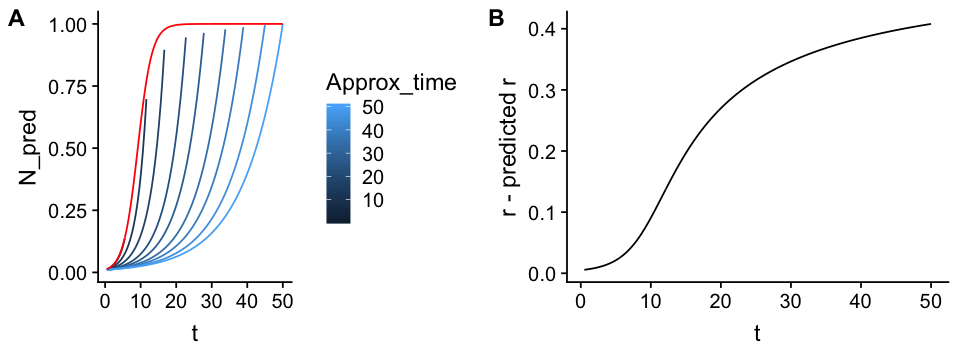

In [105]:
library(tidyverse)
library(cowplot)

r = 0.5; N0 = 0.01; K = 1
N_sim <- data.frame(t = seq(0,50,length.out = 100), r,N0, K) %>%
    mutate(N = K / (1 + ((K-N0)/(N0))*exp(-t*r))) %>%
    mutate(r_pred = (log(N)-log(N0)) / t)

#generate exponential approximates
t_app <- round(seq(1,50,length.out = 10))
r_app <- (log(K / (1 + ((K-N0)/(N0))*exp(-t_app*r))) - log(N0)) / t_app
N_app <- matrix(NA,100,10)
colnames(N_app) <- t_app

for(i in 1:10){
    N_tmp <- 0.01 * exp(r_app[i] * N_sim$t[N_sim$t <= t_app[i]])
    N_app[1:length(N_tmp),i] <- N_tmp
}

N_sim <- cbind(N_sim,as.data.frame(N_app)) %>%
    gather("Approx_time","N_pred",7:16) %>%
    mutate(Approx_time = as.numeric(Approx_time)) %>%
    filter(!is.na(N_pred),!is.na(r_pred))

p1 <- N_sim %>% 
    ggplot(aes(x = t))+
        geom_line(aes(y = N_pred, group = Approx_time, colour = Approx_time))+
        geom_line(aes(y = N),colour = "red")

p2 <- N_sim %>%
    ggplot(aes(x=t,y=r - r_pred))+
        geom_line()+
        ylab("r - predicted r")

options(repr.plot.width = 8, repr.plot.height = 3)
plot_grid(p1,p2,labels = c("A","B"))

A) Here the "real" growth curve in red is generated using the logistic growth equation with a fixed growth rate and carrying capacity. I then take the biomass across a range of time intervals and estimate $r$ using the equation above. Each of these lines represents a different time point chosen and the exponential growth curve that this generates. We can see that as the time point moves away from the exponential phase the curve becomes less and less like the logistic growth curve we are trying to approximate.B) This is showm more explictly in this plot which shows the difference in the estimated growth rate and the real growth rate (i.e. the error in our growth rate calculation) as a function of time with the difference increasing as we move away from the exponential phase. 

### Interactions

The last step is to get an estimate of the interactions between species, $a_{ij}$ . To do this we use the fact that we have (in theory) estimates of the growth of both individual species, $r_i$ and the growth rate when they are grown in pairs $r_{i_j}$ (i.e. the growth of species $i$ when grown with species $j$ including the effect of interactions). 

Taking the two species case we can write the change in biomass of each population as:

$$
    \frac{dC_{i}}{dt} = C_i (r_i - a_{ii} C_i - a_{ij} C_j) \quad \frac{dC_{j}}{dt} = C_j (r_j - a_{jj} C_j - a_{ji} C_i)
$$

Then rearanging for the $a_{ij}$ and $a_{ji}$ terms we get:

$$
    a_{ij} = \frac{\frac{dC_{j}}{dt} - r_i + a_{jj} C_i}{C_j} 
    \quad
    a_{ji} = \frac{\frac{dC_{i}}{dt} - r_j + a_{ii} C_j}{C_i}
$$

So the interaction term can be obtained by taking the difference between species growth rate and the growth of the species in isolation, divided by the con-specific density. These values all need to be evaluated at a single point in time which for convienience I take to be $t=0$. 

whilst we know the growth parameters of the species in isolation from the previous experiment we still need to estimate the growth of each species in the presence of the other. As in the experiments species are seeded at low densities and mesurements taken in exponential phase we can approximate the growth rate as:

$$
\left. \frac{dC_{i}}{dt} \right \lvert_{t = 0} \approx r_{i_j} C_i
\quad
\left. \frac{dC_{j}}{dt} \right \lvert_{t = 0} \approx r_{j_i} C_j
$$

where $r_{i_j}$ is the growth rate of species $i$ in the presence of species $j$

thus we can write the interaction terms as:

$$
    a_{ij} = \frac{r_{i_j}C - r_i + a_{jj} C_j}{C_j} 
    \quad
    a_{ji} = \frac{r_{j_i}C - r_i + a_{ii} C_j}{C_i} 
$$

#### The symmetric case

If it is not possible to establish the growth rates of each species indivdually when grown together one can make the simplifying assumption that interactions are symmetrical (i.e. $a_{ij} = a_{ji}$). This allows the interaction term to be written as a single value for the pairwise case $a$. To do this we need only yhte emergent growth rate of the pairwise combination $r_{pair}$:

$$
a = \frac{2 r_{pair} - r_i - r_j }{C_{pair}}
$$

# Parameterisation

In this section I will obtain the parameters using the methods detailed above. 

## Respiration - $R$

Species level respiration is the easiest parameter to get from the data as we have experiments that aimed to determine their TPCs directly.

In [106]:
library(rTPC)
library(nls.multstart)
library(broom)

OTU_R <- read_csv("../data/Francisca/respirationandODData//RespDataLinear_OTUs_evNev.csv",
                  col_types = cols(Sps = col_character(),
                                   T = col_double(),
                                   Replicate = col_double(),
                                   Resp = col_double(),
                                   Treatment = col_character()
                                )) %>%
mutate(OTU = as.numeric(str_replace(Sps,"R_","")),
       Resp = - Resp,
       Temp = T + 273.15) %>%
        filter(Resp > 0 )


#remove 20 & Evolved outliers (should check if this is ok...)
ind <- which((OTU_R$Treatment == "evolved") & (OTU_R$OTU == 20) & (OTU_R$Resp > 3))
OTU_R <- OTU_R[-ind,]

OTU_R_fits <- OTU_R %>%
group_by(OTU,Treatment) %>%
  nest() %>%
  mutate(., ss = map(data, ~nls_multstart(Resp ~ sharpeschoolhigh_1981(temp_k = Temp, r_tref, e, eh, th, tref = 15),
                       data = .x,
                       iter = 500,
                       start_lower = get_start_vals(.x$Temp, .x$Resp, model_name = 'sharpeschoolhigh_1981') - 5,
                       start_upper = get_start_vals(.x$Temp, .x$Resp, model_name = 'sharpeschoolhigh_1981') + 5,
                       supp_errors = 'Y')))


In [107]:
#predicting fits
newdata <- tibble(Temp = seq(min(OTU_R$Temp), max(OTU_R$Temp), length.out = 100))

OTU_R_pred <- gather(OTU_R_fits, 'model', 'output', ncol(OTU_R_fits)) %>%
  unnest(., output %>% map(augment, newdata = newdata))


OTU_R_E <- gather(OTU_R_fits, 'model', 'output', ncol(OTU_R_fits)) %>%
  mutate(., est = map(output, est_params)) %>%
  select(., -c(data, output)) %>%
  unnest(est)


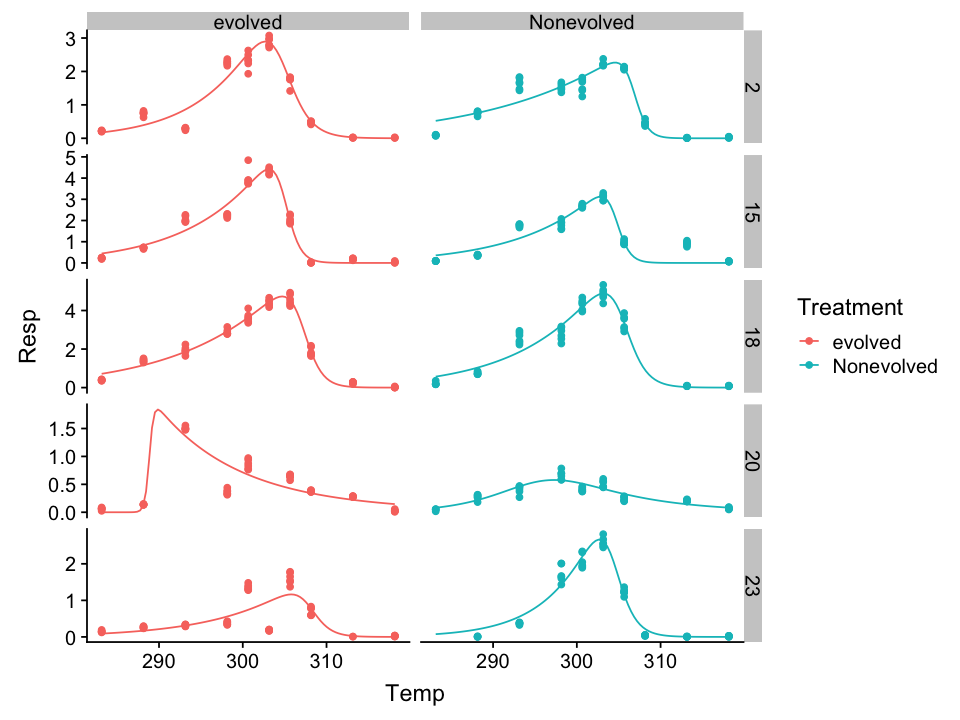

In [108]:
options(repr.plot.width = 8, repr.plot.height = 6)

OTU_R %>%
    ggplot(aes(x=Temp,y = Resp,colour=Treatment))+
    geom_point()+
    facet_grid(OTU~Treatment, scale = "free") + 
    geom_line(data = OTU_R_pred, aes(y =`.fitted`))



## Growth - $r$

Growth is slightly more complicated but as explained above we can use the OD measurements from the respiration experiments.


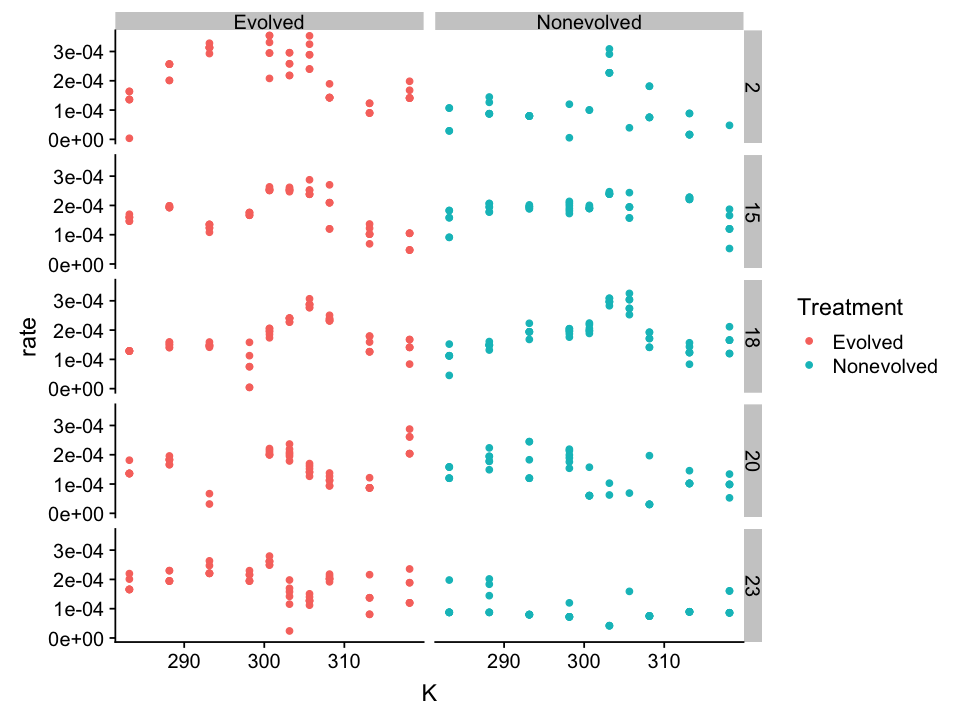

In [109]:
OTU_OD <- read_csv("../data/Francisca/respirationandODData/DatosOD_5OTUs_evNev.csv",
                   col_types = cols(
                   Replicate = col_double(),
                   OTU = col_double(),
                   OD = col_double(),
                   T = col_double(),
                   t = col_character(),
                   OD_T0 = col_double(),
                   Tf = col_double(),
                   u = col_double(),
                   Treatment = col_character()
                 ))

#get growth (need to correct for the negative growth rates)
OTU_growth <- OTU_OD %>%
    mutate(r = (log(OD) - log(OD_T0))/Tf , K = T + 273.15 ) %>%
    filter(r > quantile(r,probs = c(0.1))[1]) %>%
    mutate(rate = (r - min(r))/60) %>%
    filter(rate > 0)

OTU_growth %>%
ggplot(aes(x = K, y = rate, colour = Treatment))+
geom_point()+
facet_grid(OTU~Treatment) 

as we can see the TPCs are not great. This indicates that the approximation of growth rate from the data is problematic. This is likely because the period over which the respiration covers is not infact all exponential growth. We can see this looking at the time interval:

In [110]:
summary(OTU_growth$Tf)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  120.0   300.0   330.0   329.1   400.0   500.0 

with the average time interval being $330$ minuites, around 5 hours.

However as we just need a general idea as to the temperature sensitivty we can use the approach used by Dell et al. and just fit a boltzmann to the rising portion. Though a bit rough we can do this by taking only the points that are at temperatures lower than the maximum growth rate, and taking the slope of a linear fit between $log(r) \sim \frac{1}{kT}$.

In [138]:
k <- 8.617e-5
OTU_rising <- OTU_growth %>%
    group_by(OTU,Treatment) %>%
    mutate(rmax = max(r),Tmax = max(ifelse(r == rmax,K,0))) %>%
    filter(K <= Tmax, r > 0) %>%
    mutate(T_boltz = 1 / (K * k), r = log(r))

OTU_r_E <- OTU_rising %>%
    select(OTU,Treatment,r,T_boltz) %>%
    group_by(OTU,Treatment) %>%
    do(fit = lm(r ~ T_boltz, data = .)) %>%
    tidy(fit) %>%
    filter(term == "T_boltz") %>%
    select(OTU,Treatment,estimate) %>%
    mutate(estimate = -estimate) %>%
    rename(E = estimate) %>%
    ungroup()


OTU_r_param <- OTU_growth %>%
    filter(T == 20) %>%
    group_by(OTU,Treatment) %>%
    summarise(r = exp(mean(r))) %>%
    left_join(.,OTU_r_E)

OTU_r_param

Joining, by = c("OTU", "Treatment")


OTU,Treatment,r,E
<dbl>,<chr>,<dbl>,<dbl>
2,Evolved,1.0116158,0.7545756
2,Nonevolved,0.9975916,1.1608592
15,Evolved,1.0004053,0.4754758
15,Nonevolved,1.0044822,0.2130150
18,Evolved,1.0017056,0.8859281
18,Nonevolved,1.0044926,0.7131810
20,Evolved,0.9957790,0.1349091
20,Nonevolved,1.0031305,0.6839518
23,Evolved,1.0067644,0.2868241


So we have the temperature sensitivty of growth but we need the r0 value to calibrate. We can get this from the full growth curves which were conducted at 20C. Here full logistic curves were measured for each species at a single temperature. thus we can get the $r_0$ value (normalised to 20 degrees) with relative ease. 

In [104]:
growth_curves <- read_csv("../data/Francisca//GrowthRate20C/Pairwise_LogisticIndivcurves_Barout.csv")

OTU_r_E <- growth_curves %>%
    filter(!str_detect(Treatment,regex("\\."))) %>%
    separate(Treatment,c("OTU","Treatment"),sep = "-") %>%
    select(OTU,Treatment,mumax) %>%
    group_by(OTU,Treatment) %>%
    summarise(r0 = mean(mumax)) %>%
    ungroup()%>%
    mutate(Treatment = recode(Treatment,!!!(c("E"="Evolved","NE" = "Nonevolved"))),
           OTU = as.numeric(OTU)) %>%
    left_join(.,OTU_r_E, by = c("OTU", "Treatment"))

OTU_r_E

Warning message:
“Missing column names filled in: 'X1' [1]”Parsed with column specification:
cols(
  X1 = col_double(),
  pa = col_character(),
  LOG10Nmax = col_double(),
  LOG10N0 = col_double(),
  mumax = col_double(),
  AIC = col_double(),
  quasi.r2 = col_double(),
  Replicate = col_double(),
  Treatment = col_character()
)


OTU,Treatment,r0.x,r0.y,E
<dbl>,<chr>,<dbl>,<dbl>,<dbl>
15,Evolved,0.2426918,0.2426918,0.4754758
15,Nonevolved,0.1501864,0.1501864,0.2130150
18,Evolved,0.3682850,0.3682850,0.8859281
18,Nonevolved,0.3533238,0.3533238,0.7131810
2,Evolved,0.3109008,0.3109008,0.7545756
2,Nonevolved,0.3168000,0.3168000,1.1608592
20,Evolved,0.1489258,0.1489258,0.1349091
20,Nonevolved,0.1395252,0.1395252,0.6839518
23,Evolved,0.1719664,0.1719664,0.2868241


Thus we have a complete parameterisation of the individual growth rates TPCs. However, when we look at the $r_0$ values given by the OD measuments vs the logistic curves we see that there is a massive difference with the OD data being orders of magnitude lower than the growth curve fits. 

Joining, by = c("OTU", "Treatment")


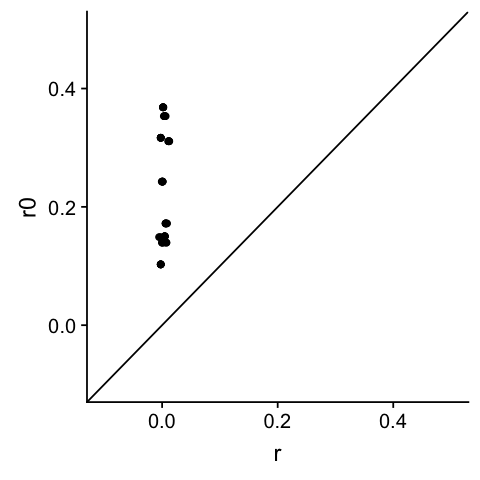

In [32]:
options(repr.plot.width = 4, repr.plot.height = 4)


OTU_growth %>%
    filter(T == 20) %>%
    left_join(OTU_r_E) %>%
    ggplot()+
    geom_point(aes(x = r, y = r0)) +
    geom_abline(intercept = 0, slope = 1) +
    xlim(-0.1,0.5) + ylim(-0.1,0.5)

Clearly something is wrong with the parameterisation using the OD data from the respiration experiments.

## Interactions

Finally we want to determine what the interaction parameters are. As we have only measurements of total biomass we must assume symmetrical interactions for now. To do this we first get the total growth rate of each pairwise combination and fit a TPC.

In [62]:
#read in data
pairs_growth <- read_csv("../data/Francisca/respirationandODData/DatosOD_PairsevNev_u.csv",
                         col_types = cols(
                                      Replicate = col_double(),
                                      OTU = col_character(),
                                      OD = col_double(),
                                      T = col_double(),
                                      t = col_character(),
                                      OD_T0 = col_double(),
                                      Tf = col_double(),
                                      u = col_double(),
                                      Treatment = col_character()
                         ))


pairs_growth_data <- pairs_growth %>%
    mutate(OTU = str_replace(OTU,"Feb","2")) %>%
    separate(OTU,c("OTU_1","OTU_2"),sep = "-")%>%
#get growthrate (k) and temp in kelvin (K)
     mutate(r = (log(OD) - log(OD_T0))/Tf , K = T + 273.15 ) %>%
#clean up data 
    mutate(r = r - min(r),
           OTU_1 = as.numeric(OTU_1),
           OTU_2 = as.numeric(OTU_2),
           Treatment = str_to_title(Treatment)) %>%
    filter(r != 0)

pairs_grow_fits <- pairs_growth_data %>%
    group_by(OTU_1,OTU_2,Treatment) %>%
    nest() %>%
    mutate(., ss = map(data, ~nls_multstart(r ~ sharpeschoolhigh_1981(temp_k = K, r_tref, e, eh, th, tref = 20),
                       data = .x,
                       iter = 1000,
                       start_lower = get_start_vals(.x$K, .x$r, model_name = 'sharpeschoolhigh_1981') - 5,
                       start_upper = get_start_vals(.x$K, .x$r, model_name = 'sharpeschoolhigh_1981') + 5,
                       supp_errors = 'Y')))


Warning message in runif(iter, .x, .y):
“NAs produced”

In [63]:
#predicting fits
newdata <- tibble(K = seq(min(pairs_growth_data$K), max(pairs_growth_data$K), length.out = 100))

pairs_grow_pred <- gather(pairs_grow_fits, 'model', 'output', ncol(pairs_grow_fits)) %>%
    unnest(., output %>% map(augment, newdata = newdata))


pair_grow_E <- gather(pairs_grow_fits, 'model', 'output', ncol(pairs_grow_fits)) %>%
  mutate(., est = map(output, est_params)) %>%
  select(., -c(data, output)) %>%
  unnest(est)

pair_grow_E

Warning message in max(newdata_extrap[, param_ind], na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”Warning message in max(newdata_extrap[, param_ind], na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”Warning message in max(newdata_extrap[, param_ind], na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”Warning message in max(newdata_extrap[, param_ind], na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”Warning message in min(newdata_extrap[, param_ind], na.rm = TRUE):
“no non-missing arguments to min; returning Inf”Warning message in max(newdata_extrap[, param_ind], na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”Warning message in min(newdata_extrap[, param_ind], na.rm = TRUE):
“no non-missing arguments to min; returning Inf”Warning message in max(newdata_extrap[, param_ind], na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”Warning message in max(newdata_extrap[, param_ind], na.rm = TRUE):
“no non

OTU_1,OTU_2,Treatment,model,rmax,topt,ctmin,ctmax,e,eh,q10,thermal_safety_margin,tolerance_range,skewness
<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2,15,Evolved,ss,0.08747009,301.448,-Inf,363.420,0.007707368,0.11158594,1.0101893,61.972,Inf,2.398379e-03
2,18,Evolved,ss,0.09184486,308.212,-Inf,342.654,0.031441317,0.13181743,1.0427407,34.442,Inf,-2.964349e-16
2,20,Evolved,ss,0.08644572,309.415,-Inf,339.585,0.021733601,0.10962571,1.0292867,30.170,Inf,-2.964349e-16
2,23,Evolved,ss,0.08677433,296.260,-Inf,Inf,-0.058179049,0.03249510,0.9213567,Inf,Inf,-2.964349e-16
15,18,Evolved,ss,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
15,20,Evolved,ss,0.08504964,301.085,-Inf,Inf,0.012623888,0.05310287,1.0173637,Inf,Inf,-2.964349e-16
15,23,Evolved,ss,0.08791930,303.517,-Inf,349.216,0.018297369,0.17853054,1.0250763,45.699,Inf,2.398379e-03
18,20,Evolved,ss,0.08736083,306.481,-Inf,Inf,0.046563642,0.05787167,1.0651000,Inf,Inf,-2.964349e-16
18,23,Evolved,ss,0.08504535,302.295,-Inf,357.750,0.013210498,0.12483442,1.0178894,55.455,Inf,2.398379e-03


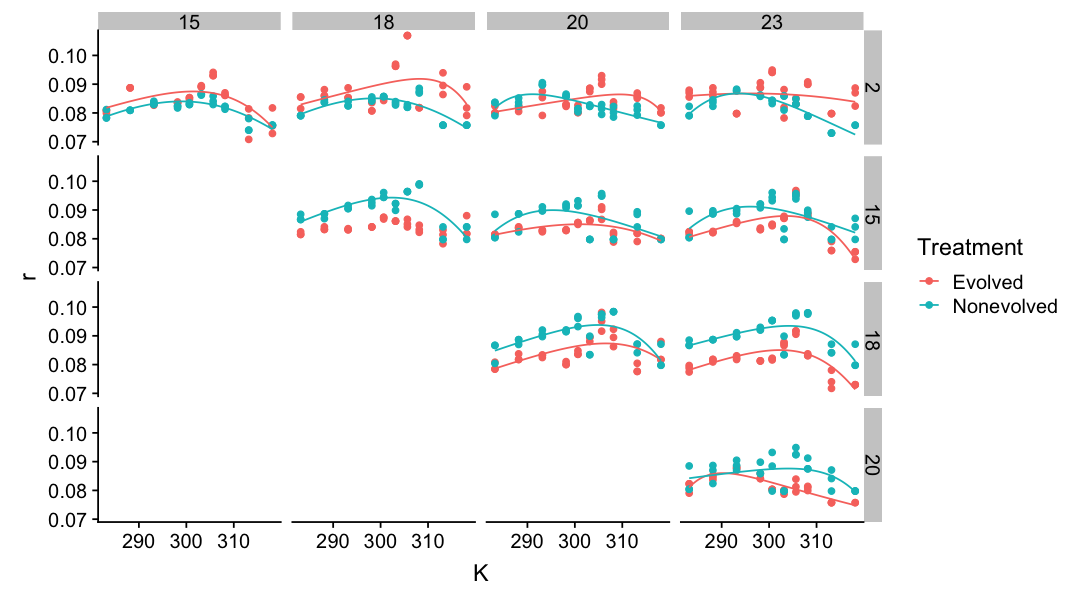

In [64]:
options(repr.plot.width = 9, repr.plot.height = 5)

pairs_growth_data %>%
    ggplot(aes(x=K,y = r,colour=Treatment))+
    geom_point()+
    facet_grid(OTU_1~OTU_2)+
    geom_line(data = pairs_grow_pred, aes(y =`.fitted`))

Joining, by = c("OTU_1", "OTU_2", "Treatment", "K")
Warning message:
“Removed 30 rows containing missing values (geom_point).”

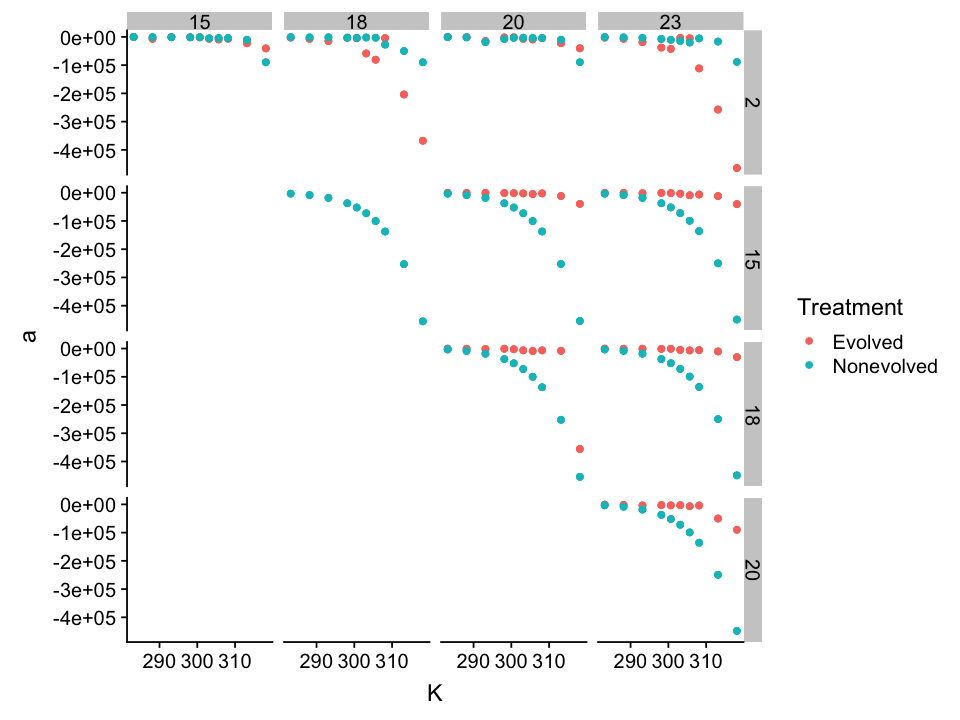

In [147]:
pairs_growth <- read_csv("../data/Francisca/respirationandODData/DatosOD_PairsevNev_u.csv",
                         col_types = cols(
                                      Replicate = col_double(),
                                      OTU = col_character(),
                                      OD = col_double(),
                                      T = col_double(),
                                      t = col_character(),
                                      OD_T0 = col_double(),
                                      Tf = col_double(),
                                      u = col_double(),
                                      Treatment = col_character()
                         ))


newdata <- tibble(K = pairs_growth_data$K)  

pairs_grow_pred <- gather(pairs_grow_fits, 'model', 'output', ncol(pairs_grow_fits)) %>%
    unnest(., output %>% map(augment, newdata = newdata)) %>%
    unique()

OTU_r_param <- OTU_r_param %>%
    mutate(ind = paste(OTU,Treatment,sep="-"))

r0_ind <- OTU_r_param$r
names(r0_ind) <- OTU_r_param$ind

E_ind <- OTU_r_param$r
names(E_ind) <- OTU_r_param$ind


left_join(pairs_growth_data,pairs_grow_pred) %>%
    #add in params
    mutate(r0_1 = paste(OTU_1,Treatment,sep = "-"),E_1 = r0_1,
           r0_2 = paste(OTU_2,Treatment,sep = "-"),E_2 = r0_2) %>%
    mutate(r0_1 = recode(r0_1,!!!r0_ind),E_1 = recode(E_1,!!!E_ind),
           r0_2 = recode(r0_2,!!!r0_ind),E_2 = recode(E_2,!!!E_ind))  %>%
    mutate(r_1 = r0_1 * exp((-E_1/k) * ((1/K) - (1/293.15)) ),
           r_2 = r0_2 * exp((-E_2/k) * ((1/K) - (1/293.15)) )) %>%
    mutate(a = (2*.fitted - r_1 - r_2) / OD_T0 ) %>%
    select(OTU_1,OTU_2,Treatment,K,a) %>%
    ggplot(aes(x = K, y = a, colour = Treatment))+
        geom_point()+
        facet_grid(OTU_1~OTU_2)

and then the $r_0$ values

In [95]:
#interactions growth data
growth_curves <- read_csv("../data/Francisca//GrowthRate20C/Pairwise_LogisticIndivcurves_Barout.csv",
                          col_types = cols(
                                          X1 = col_double(),
                                          pa = col_character(),
                                          LOG10Nmax = col_double(),
                                          LOG10N0 = col_double(),
                                          mumax = col_double(),
                                          AIC = col_double(),
                                          quasi.r2 = col_double(),
                                          Replicate = col_double(),
                                          Treatment = col_character()
                                          ))

#get the pairs
pair_grw <- growth_curves %>% filter(str_detect(Treatment,regex("[0-9]*\\.[0-9]*",ignore_case = T)))
pair_grw_r0 <- pair_grw %>%
    separate(pa,c("x","y"),sep = "-") %>%
    separate(x,c("OTU_1","OTU_2")) %>%
    separate(y,c("Treatment","Replicate"),sep = ":") %>%
    select(OTU_1,OTU_2,Treatment,Replicate,r0 = mumax) %>%
    mutate(Treatment = recode(Treatment,"E" = "Evolved", "NE" = "Nonevolved"))

pair_grw_r0

Warning message:
“Missing column names filled in: 'X1' [1]”

OTU_1,OTU_2,Treatment,Replicate,r0
<chr>,<chr>,<chr>,<chr>,<dbl>
15,18,Evolved,R1,0.1601670
15,18,Evolved,R2,0.1118508
15,18,Evolved,R3,0.1198165
15,18,Evolved,R4,0.1197483
15,18,Evolved,R5,0.1072075
15,18,Evolved,R6,0.1462741
15,18,Nonevolved,R1,0.3641959
15,18,Nonevolved,R2,0.3869097
15,18,Nonevolved,R3,0.3594997


In [139]:
Now we have both the TPC

ERROR: Error in parse(text = x, srcfile = src): <text>:1:5: unexpected symbol
1: Now we
        ^


In [283]:
#read in data
pairs_growth <- read_csv("../data/Francisca/respirationandODData/DatosOD_PairsevNev_u.csv",
                         col_types = cols(
                                      Replicate = col_double(),
                                      OTU = col_character(),
                                      OD = col_double(),
                                      T = col_double(),
                                      t = col_character(),
                                      OD_T0 = col_double(),
                                      Tf = col_double(),
                                      u = col_double(),
                                      Treatment = col_character()
                         ))


#create index for r0 and E values
r0_ind <- c(OTU_r_E$r0)
names(r0_ind) <- paste(OTU_r_E$OTU,OTU_r_E$Treatment,sep="-")

E_ind <- c(OTU_r_E$E)
names(E_ind) <- paste(OTU_r_E$OTU,OTU_r_E$Treatment,sep="-")

#parse interactions
pairs_growth_data <- pairs_growth %>%
    mutate(OTU = str_replace(OTU,"Feb","2")) %>%
    separate(OTU,c("OTU_1","OTU_2"),sep = "-")%>%
#get growthrate (k) and temp in kelvin (K)
     mutate(r = (log(OD) - log(OD_T0))/Tf , K = T + 273.15 ) %>%
#clean up data 
    mutate(r = r - min(r),
           OTU_1 = as.numeric(OTU_1),
           OTU_2 = as.numeric(OTU_2),
           Treatment = str_to_title(Treatment)) %>%
#get index names
    mutate(r0_1 = paste(OTU_1,Treatment,sep = "-"),E_1 = r0_1,
           r0_2 = paste(OTU_2,Treatment,sep = "-"),E_2 = r0_2) %>%
#recode to get r0 and E values    
    mutate(r0_1 = recode(r0_1,!!!r0_ind),E_1 = recode(E_1,!!!E_ind),
           r0_2 = recode(r0_2,!!!r0_ind),E_2 = recode(E_2,!!!E_ind)) %>%
#work out r values (at a given Temp)
    mutate(r_1 = r0_1 * exp(-(E_1 / k) * ((1 / K)-(1/293.15)) ),
           r_2 = r0_2 * exp(-(E_2 / k) * ((1 / K)-(1/293.15)) )) %>%
    select(Replicate,OTU_1,OTU_2,Treatment,K,OD_T0,OD,r_pair = r,r_1,r_2) %>%
    mutate(a = (2*r_pair - r_1 - r_2)/OD_T0) %>%
    filter(K < 300)

pairs_growth_data

Replicate,OTU_1,OTU_2,Treatment,K,OD_T0,OD,r_pair,r_1,r_2,a
<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2,15,Evolved,283.15,0.002125,0.003250,0.08083303,0.1082565,0.1248398,-33.61422
2,2,15,Evolved,283.15,0.002125,0.002250,0.07991371,0.1082565,0.1248398,-34.47945
3,2,15,Evolved,283.15,0.002125,0.003250,0.08083303,0.1082565,0.1248398,-33.61422
1,2,18,Evolved,283.15,0.000125,0.001250,0.08552728,0.1082565,0.1067237,-351.40522
2,2,18,Evolved,283.15,0.000125,0.000250,0.08150369,0.1082565,0.1067237,-415.78273
3,2,18,Evolved,283.15,0.000125,0.001250,0.08552728,0.1082565,0.1067237,-351.40522
1,2,20,Evolved,283.15,0.001125,0.001250,0.08003422,0.1082565,0.1233261,-63.56813
2,2,20,Evolved,283.15,0.001125,0.001250,0.08003422,0.1082565,0.1233261,-63.56813
3,2,20,Evolved,283.15,0.001125,0.003250,0.08242300,0.1082565,0.1233261,-59.32141


This dataframe contains the logistic fits for all pairwise combinations in addition to the single species curves. thus, we need to separate these out

In [13]:
#split single species and pairwise fits
pair_grw <- growth_curves %>% filter(str_detect(Treatment,regex("[0-9]*\\.[0-9]*",ignore_case = T)))
sing_grw <- growth_curves %>% filter(!str_detect(Treatment,regex("[0-9]*\\.[0-9]*",ignore_case = T)))

#tidy up growthrates
single <- sing_grw %>% 
    separate(Treatment,c("OTU","Treatment")) %>%
    select(OTU,Treatment,Replicate,K = LOG10Nmax,N0 = LOG10N0,r = mumax) %>%
    mutate(K = 10^K, N0 = 10^N0)

pairwise <- pair_grw %>%
    separate(Treatment,c("OTU","Treatment"),sep = "-") %>%
    separate(OTU,c("OTU_1","OTU_2")) %>%
    select(OTU_1,OTU_2,Treatment,Replicate,K = LOG10Nmax,N0 = LOG10N0,r = mumax) %>%
    mutate(K = 10^K, N0 = 10^N0)


In [82]:
##estimating growth rates
#summarise growth rates across groups
mean_r_single <- single %>% group_by(OTU,Treatment) %>%
    summarise(r = mean(r))

mean_r_pair <- pairwise %>% group_by(OTU_1,OTU_2,Treatment) %>%
    summarise(r = mean(r), N0 = mean(N0))

#function to get the expected growth with no interactions (via linearlised exponential growth)
get_pair_r_exp <- function(Treat,OTU_1,OTU_2,N0,t_max){
    #get growth rates
    r_vec <- mean_r_single %>%
    filter(Treatment == Treat, OTU %in% c(OTU_1,OTU_2)) %>%
    .$r
    
    #allocate N vector
    N_vec <- vector(length = 100)
    for(i in 1:100){
        N_vec[i] <- sum(rep(N0,2) * exp(r_vec*seq(0,t_max,length.out = 100)[i]))
    }

    r_pair = coef(lm(log(N_vec)~seq(0,t_max,length.out = 100)))[2]

    return(r_pair)
}

r_interactions <- mean_r_pair %>%
    mutate(r_null = get_pair_r_exp(Treatment,OTU_1,OTU_2,N0/2,10),
           r_diff = r / r_null)

r_interactions

OTU_1,OTU_2,Treatment,r,N0,r_null,r_diff
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
15,18,E,0.12751070,0.021071364,0.3174811,0.4016324
15,18,NE,0.40513504,0.008334477,0.3174811,1.2760919
15,20,E,0.18259778,0.016120275,0.1755808,1.0399643
15,20,NE,0.13705277,0.021931893,0.1755808,0.7805680
15,23,E,0.19435895,0.012274014,0.1788188,1.0869044
15,23,NE,0.11722597,0.012994489,0.1788188,0.6555573
18,20,E,0.29915044,0.007625384,0.3027300,0.9881758
18,20,NE,0.32361771,0.010798027,0.3027300,1.0689979
18,23,E,0.34911981,0.002472549,0.3015289,1.1578318


And for the $E$ values we again look at the respiration measures:

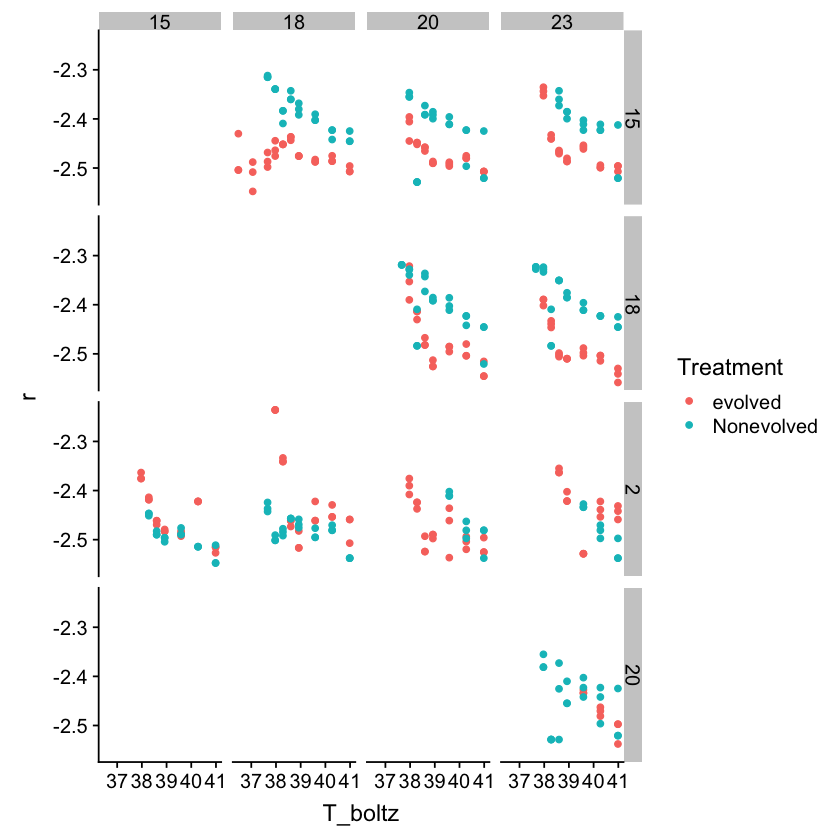

In [83]:
pairs_growth <- read_csv("../data/Francisca/respirationandODData/DatosOD_PairsevNev_u.csv",
                         col_types = cols(
                                      Replicate = col_double(),
                                      OTU = col_character(),
                                      OD = col_double(),
                                      T = col_double(),
                                      t = col_character(),
                                      OD_T0 = col_double(),
                                      Tf = col_double(),
                                      u = col_double(),
                                      Treatment = col_character()
                                    ))
#parse interactions
pairs_growth_data <- pairs_growth %>%
    mutate(OTU = str_replace(OTU,"Feb","2")) %>%
    separate(OTU,c("OTU_1","OTU_2"),sep = "-")%>%
#get growthrate (k) and temp in kelvin (K)
     mutate(r = (log(OD) - log(OD_T0))/Tf , K = T + 273.15 ) %>%
#clean up data 
    mutate(r = r - min(r))

#andn then taking the rising portion
pair_rising <- pairs_growth_data %>%
    group_by(OTU_1,OTU_2,Treatment) %>%
    mutate(rmax = max(r),Tmax = max(ifelse(r == rmax,K,0))) %>%
    filter(K <= Tmax, r > 0) %>%
    mutate(T_boltz = 1 / (K * k), r = log(r))

pair_rising %>% 
ggplot(aes(x = T_boltz, y = r, color = Treatment))+
    geom_point() +
    facet_grid(OTU_1~OTU_2)